In [4]:
import numpy as np
from IPython.display import display, clear_output
import time
import itertools
import matplotlib.pyplot as plt

# Elevator environment

We consider a single elevator operated by an agent, for now we also only consider the down peak scenario. This means thats all request or calls are from someone who wants to go from an random floor to the ground floor.

Unlike what is done is the paper, we don't consider the speed of the elevator and slightly modify their modelisation. To model the single elevator problem, one can remark that any successive operations done by the elevator can be expressed in basic "blocks".

Indeed, consider the following blocks :

    - Moving one floor up
    - Moving one floor down
    - Waiting at current floor
    - Taking people in 
    - People exiting
    
Now, each of these actions takes at certain amount of amount which is not necessarily constant (i.e. the last block of "people exiting" takes an amount of time which depend on the number of people exiting and the people themselves). Any observed sequence of actions taken by an elevator can be decomposed using these simple blocks (allowing for multiplication of the first and second actions). If we look at a sequence of actions, the time it will take should depend in principle on a lot of variables.

Following what was done in the referenced paper, with some simplifications we model the actions undertook by the elevator by these 5 blocks. We will also assume that each of these actions (or blocks) takes one unit of time, this is of course not very realistic but this will simplify the implementation. For examples, it allows us to say that if the elevator moves from floor 0 to floor 3 in one go, it is the same (in terms of time consumed) as moving from successively moving from 0 to 1, 1 to 2 and 2 to 3. Furthermore, we force the elevator to take people in if it passes by a floor where there is call and if the current capacity allows for it.

Finally, an important simplification which is made is in the modelisation of calls. A call happens when someone presses the button at a floor (in our framework the call only means the person wants to go to the ground floor). Calls will be randomly drawn from a discrete distribution, and we will assume that a call counts for 1 person (1 unit of capacity of the elevator) and once the call is made no other call can be made until this person enters the elevator. This is of course a strong assumption.

In [68]:
class ELEVATOR():
    """ This object will serve to model a simple elevator and its environment which is the building. 
        To simplify, only one elevator is considered.
        
        
    """
    def __init__(self, n_floor=4, capacity=4, occupancy=0, floor=0, 
                 call_probas = [0.6875, 0.0625, 0.09375, 0.09375, 0.0625]):
        """  
            Initialisation 
            -------------
            Parameters :
                n_floor : int, number of floor 
                capacity : int, capacity of the elevator
                occupancy : int, 0, initial occupancy 
                floor : int, floor where the elevator is located
                call_probas : list, sum to 1 and gives probability a call is made at floors
            ------------
            Attributes :
                waiting_times : list, will store the waiting time of passengers
                start_times : dict, gives the time at which passenger e made a call
                passengers : list of passenger ids
                in_transit : set, passenger currently in the elevator
                arrived : list, passenger that have exited the elevator in the ground floor
                          and are no longer in the system. 
        """
        self.n_floor = n_floor
        self.capacity = capacity
        self.occupancy = occupancy
        self.floor = floor
        self.time = 0
        self.calls = {i : 0 for i in range(0, n_floor + 1)}
        self.call_probas = call_probas
        
        self.waiting_times = []
        self.start_times = {}
        self.passengers = []
        self.in_transit = set()
        self.arrived = []
        
    def update_env(self):
        """ Updates the environments.
            If elevator is at ground floor, then all passengers exit
            If it is in another floor, if a passenger is waiting and capacity allows then
            new passenger comes in.
            This is done while keeping track of which passenger gets in and off the elevator 
            in order to measure waiting times.
        
        """
        if self.floor == 0:
            if self.occupancy > 0:
                self.deposited += self.occupancy
                self.time += 1 #adding a time unit if 
                self.occupancy = 0 #emptying the elevator
                for pid in self.in_transit:
                    self.waiting_times.append(self.time - self.start_times[pid])
                    self.arrived.append(pid)
                self.in_transit = set()
                    
        elif self.calls[self.floor]>0 and self.occupancy < self.capacity:
            self.occupancy += 1 #min(self.capacity - self.occupancy, self.calls[self.floor])
            for pid in self.passengers:
                if not(pid in self.in_transit.union(self.arrived)):
                    if pid[0] == self.floor:
                        self.in_transit = self.in_transit.union(set([pid]))
            
            self.calls[self.floor] = 0 #min(self.capacity - self.occupancy, self.calls[self.floor])
            self.time += 1
        
        
    
    def move(self, direction):
        """ Moves the elevator using direction parameters. 
            After each move, the time increases by one unit of time.
            ----------
            Params:
                direction : 1 move up, -1 move down, 0 wait
            ----------
            
        """
        self.floor = self.floor + direction
        self.time += 1
        self.update_env()
    
    
    def generate_calls(self):
        """ Generates an event (i.e. a call) using the self.call_probas distributions.
            If event 0 is drawn it means no call is made.
            An event e > 0 drawn means a call is made at floor e.
            --------
            Important assumption : once a call is made in a floor, no call can be made from
            that floor until the first one is served. This means that we only allow for one 
            person to be waiting for the elevator at a given floor. (See report for details)
        
        """
        event = np.random.choice([i for i in range(self.n_floor+1)], p=self.call_probas)
        if event > 0 and self.calls[event] == 0:
            self.calls[event] = 1
            passenger_id = (event, self.time)
            self.passengers.append(passenger_id)
            self.start_times[passenger_id] = self.time
            
        self.update_env()
        
    def print_current_state(self):
        """ Displays the current state of the system. 
            When called repeatedly, it can display the environement evolving.
            
        """
        clear_output(wait=True)
        for k in range(self.n_floor, -1, -1):
            print("  ======")
            if self.floor == k:
                print("||   E  ||", "*" * self.calls[k])
            else:
                print("||      ||", "*" * self.calls[k])
        print("")
        print("Elevator occupancy :", self.occupancy)
        print("Elevator is on floor :", self.floor)
        print("")
        print("On the schema, the E represent the position of the elevator, * represent calls. Floors ")
        print("are represented between the ====== separations.")

**An example of how the environment evolves if we apply random moves**

In [122]:
ev = ELEVATOR()

In [94]:
for t in range(20):
    if ev.floor == 0:
        next_move = np.random.choice([1, 0])
    elif ev.floor == ev.n_floor:
        next_move = np.random.choice([-1, 0])
    else:
        next_move = np.random.choice([-1, 0, 1])
    ev.generate_calls()
    ev.print_current_state()
    ev.move(next_move)
    ev.print_current_state()
    time.sleep(0.5)

||      || *
||   E  || 
||      || 
||      || 
||      || 

Elevator occupancy : 4
Elevator is on floor : 3

On the schema, the E represent the position of the elevator, * represent calls. Floors 
are represented between the ====== separations.


In [98]:
ev.passengers, ev.in_transit, ev.waiting_times, ev.time, ev.arrived

([(2, 1), (2, 11)], set(), [8], 12, [(2, 1)])

## State - Space definition

The state space in this simple model is defined in a 6 dimensional space $\mathbb{X}$. 
Any $x$ in $\mathbb{X}$ can be written as $x = [c_1, c_2, c_3, c_4, p, o]$ where :

    - c_i is equal to 1 iif there if a call on floor i, 0 otherwise. There is no call in floor 0 in our scenario (down peak)
    - p (0,1,2,3,4) indicates the position of the elevator
    - o (0,1,2,3,4) indicates the occupancy of the elevator
    

As detailed earlier we made some simplifications which imply that we don't have the speed variable anymore. So this state space has a cardinality of : $2^4 \cdot 5 \cdot 5 = 400$

## Action Space definition

The agent controls the elevator and can choose his action among 3 possibilities : moving up, down or waiting. We encode these by +1, -1 and 0.

So in each state, the agent choses one of these 3 actions.

## Rewards definition

At time step $t$, the agent finds himself in state $x_t$, we will define the reward as :

$$
r(x_t) = -\sum_{i=1}^{4} c_i - o
$$


So the agent will be penalized by the number of people waiting to reach the ground floor, either because they are waiting in a floor on in the elevator. 

# Q Learning

We first define the mapping from (state, action) to values with all zero values. For now, let us store these values in a dictionnary. It is important to note that the following is computationnaly possible only because the parameters of the problem were chosen so that the State space is small enough (also the motiviation for a simple model provided in the paper).


In [99]:
c_1 = [0, 1] #call in floor 1
c_2 = [0, 1] #call in floor 2
c_3 = [0, 1] #call in floor 3
c_4 = [0, 1] #call in floor 4
p = [0, 1, 2, 3, 4] #position of the elevator
o = [0, 1, 2, 3, 4] #occupancy of the elevator
states = list(itertools.product(c_1, c_2, c_3, c_4, p, o)) #all possible states

In [100]:
#filling the state action values with 0
def init_Q():
    Q = {} #initializing a dictionnary for the state action values
    for s in states:
        for a in [-1, 0, 1]:
            Q[(s, a)] = 0#np.random.randn()*0.002
    return Q

In [101]:
def Q_learning(Q, gamma, epsilon, tau, T, episode, eps_anneal, tau_anneal, lr=None):
    """ Q Learning algorithm
        --------
        Params :
            Q : Dict, storing state action values
            gamma : float in (0,1], discount factor
            epsilon : float in (0,1), for the epsilon greedy selection
            tau : positive float, for the boltzmann distribution
            T : int, number of time step during one episode
            episode : int, number of episode
            eps_anneal : float in (0, 1), annealing factor for epsilon, applied every episode
            tau_anneal : float in (0, 1), annealing factor for tau, applied every time step
            lr : float, learning rate. If None, 1./t will be used 
        --------
        Returns :
            served_person : list, served passenger by episode
            rewards : dict, rewards obtained during each episode
            waiting_times : dict, contains list of waiting times for each episode
    """
    rewards = {}
    served_person = []
    waiting_times = {}
    for ep in range(episode):
        #init environement for new episode
        env = ELEVATOR()
        rewards[ep] = []
        while env.time < T:
        #for t in range(T):
            actions = [-1, 0, 1] #default actions
            #first determine possible actions
            if env.floor == 0 :
                actions = [0, 1]
            if env.floor == env.n_floor :
                actions = [-1, 0] 
            if env.occupancy == env.capacity:
                actions = [-1]
            #draw calls for time step t
            env.generate_calls()
            xt = (min(env.calls[0],1), min(env.calls[1],1), min(env.calls[2],1), min(env.calls[3],1), env.floor, env.occupancy)
            #start epsilon greedy procedure
            u = np.random.random()
            if u >= epsilon: #with proba 1-epsilon this happens
                action_idx = np.argmax([Q[(xt, actions[i])] for i in range(len(actions))]) #greedy choice
                a = actions[action_idx]

            else: #with proba epsilon this happens
                #select an action using current Q values and boltzman distribution
                actions_probas = []
                for a in actions:
                    actions_probas.append(np.exp(np.clip(Q[(xt, a)]/tau, 0, 50))) #clipping because of overflow

                actions_probas = np.array(actions_probas) / np.sum(actions_probas) #normalizing
                a = np.random.choice(actions, 1, p=actions_probas)[0]

            env.move(a) #realise the chosen action
            r = - env.occupancy - sum(env.calls.values()) #+ env.deposited#compute and observe the reward
            rewards[ep].append(r) #store the reward for monitoring
            x_new = (min(env.calls[0],1), min(env.calls[1],1), min(env.calls[2],1), min(env.calls[3],1), env.floor, env.occupancy) #observe new state
            #----------------
            #Now the reward is observed, update the Q value using Bellman equation
            #----------------
            if not(lr): #if no learning rate was specified
                lr = 1./(t+1) #setting the learning rate s.t. sum is infinite but squared sum is finite
            #get possible future actions from new state
            future_actions = [-1,0,1]
            if env.floor == 0 :
                future_actions = [0, 1]
            if env.floor == env.n_floor :
                future_actions = [-1, 0] 
            if env.occupancy == env.capacity:
                future_actions = [-1]

            best_future_action = future_actions[np.argmax([Q[(x_new, future_actions[i])] for i in range(len(future_actions))])] #get best future action
            #update Q
            Q[(xt, a)] += lr * (r + gamma * Q[(x_new, best_future_action)] - Q[(xt, a)])
            xt = x_new #updating the state
            tau = tau * tau_anneal #annealing the temperature
        #----END EPISODE------
            
        epsilon = epsilon * eps_anneal #annealing epsilon between episodes 
        #storing number of people "served" during this episode
        served_person.append(env.deposited)
        #storing waiting times during this episode
        waiting_times[ep] = env.waiting_times
        
    return served_person, rewards, waiting_times

In [102]:
#setting parameters using what was done in the paper
gamma = 0.99
lr = 0.38
epsilon = 0.85
tau = 10
eps_anneal = 0.89
tau_anneal = 0.998
T = 500 # time steps for one episode
episode = 250 #number of episode

In [103]:
Q = init_Q()

In [104]:
served_person, rewards, waiting_times = Q_learning(Q, gamma, epsilon, tau, T, episode, eps_anneal, tau_anneal, lr)

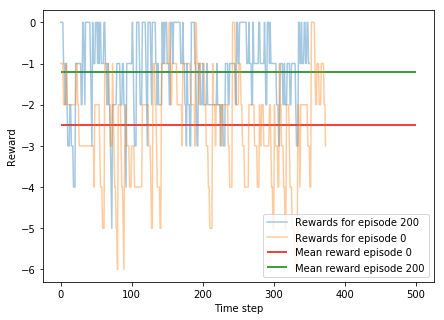

In [105]:
plt.figure(figsize=(7,5))
plt.plot(rewards[200], label="Rewards for episode 200", alpha = 0.4)
plt.plot(rewards[0], label="Rewards for episode 0", alpha = 0.4)
plt.hlines(np.mean(rewards[0]), xmin=0, xmax=500, label="Mean reward episode 0", color="red")
plt.hlines(np.mean(rewards[200]), xmin=0, xmax=500, label="Mean reward episode 200", color="green")
plt.legend()
plt.xlabel("Time step")
plt.ylabel("Reward")
plt.show()

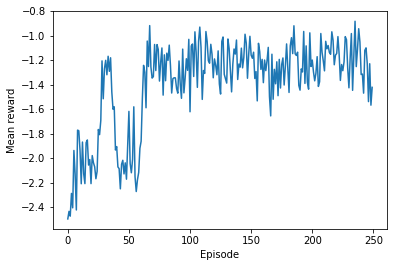

In [106]:
mean_rewards = [np.mean(rewards[e]) for e in rewards]
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean reward")
plt.show()

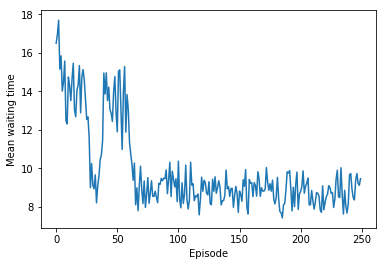

In [108]:
mean_waiting_time = [np.mean(waiting_times[e]) for e in waiting_times]
plt.plot(mean_waiting_time)
plt.xlabel("Episode")
plt.ylabel("Mean waiting time")
plt.show()

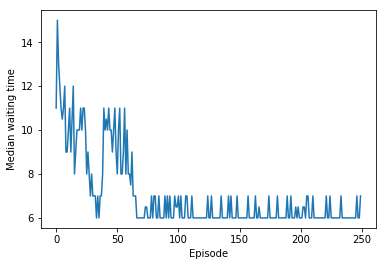

In [137]:
median_waiting_time = [np.median(waiting_times[e]) for e in waiting_times]
plt.plot(median_waiting_time)
plt.xlabel("Episode")
plt.ylabel("Median waiting time")
plt.show()

In [132]:
np.mean(mean_waiting_time[70:]), np.std(mean_waiting_time[70:])

(8.819128938774352, 0.6375415319426248)

In [118]:
def implement_policy(Q, T):
    """ Implement the policy Q and display corresponding simulation.
        --------
        Params :
            Q : dict, contains all state action values
            T : int, number of time step to simulate
        --------
        Returns : 
            None
    """
    ev = ELEVATOR()
    xt = (ev.calls[0], ev.calls[1], ev.calls[2], ev.calls[3], ev.floor, ev.occupancy)
    ev.print_current_state()
    time.sleep(0.5)
    while ev.time < T:
   
        actions = [-1, 0, 1]
        if ev.floor == 0 :
            actions = [0, 1]
        if ev.floor == ev.n_floor :
            actions = [-1, 0]
        if ev.occupancy == ev.capacity:
            actions = [-1]
                
        np.random.shuffle(actions)
        action_idx = np.argmax([Q[(xt, actions[i])] for i in range(len(actions))]) #greedy choice
        a = actions[action_idx]
        ev.move(a)
        ev.print_current_state()
        ev.generate_calls()
        xt = (ev.calls[0], ev.calls[1], ev.calls[2], ev.calls[3], ev.floor, ev.occupancy) #get new state
        ev.print_current_state()
        time.sleep(0.5)

In [119]:
implement_policy(Q, 20)

||      || 
||      || 
||   E  || 
||      || 
||      || 

Elevator occupancy : 0
Elevator is on floor : 2

On the schema, the E represent the position of the elevator, * represent calls. Floors 
are represented between the ====== separations.


# Q($\lambda$)

In [153]:
def Q_lambda(Q, gamma, epsilon, tau, T, episode, eps_anneal, tau_anneal, lbda, lr=None):
    """ Q lambda algorithms, close variant of Q learning
        --------
        Params :
            Q : Dict, storing state action values
            gamma : float in (0,1], discount factor
            epsilon : float in (0,1), for the epsilon greedy selection
            tau : positive float, for the boltzmann distribution
            T : int, number of time step during one episode
            episode : int, number of episode
            eps_anneal : float in (0, 1), annealing factor for epsilon, applied every episode
            tau_anneal : float in (0, 1), annealing factor for tau, applied every time step
            lr : float, learning rate. If None, 1./t will be used 
            lbda : float, elegibility trace parameter
        -------
        Returns :
            rewards : dict, contains list of rewards for each episode
            waiting_times : dict, contains list of waiting times for each episode
    """
    rewards = {}
    served_person = []
    waiting_times = {}
    E = init_Q()
    for ep in range(episode):
        #init environement for new episode
        env = ELEVATOR()
        rewards[ep] = []
        a = np.random.choice([0,1], 1)[0]
        x = (env.calls[0], env.calls[1], env.calls[2], env.calls[3], env.floor, env.occupancy)
        while env.time < T:
        #for t in range(T):
        
            env.move(a) #realise the chosen action
            env.generate_calls()
            r = - env.occupancy - sum(env.calls.values()) 
            rewards[ep].append(r)
            x_new = (env.calls[0], env.calls[1], env.calls[2], env.calls[3], env.floor, env.occupancy)
            
            actions = [-1, 0, 1] #default actions
            #first determine possible actions
            if env.floor == 0 :
                actions = [0, 1]
            if env.floor == env.n_floor :
                actions = [-1, 0] 
            if env.occupancy == env.capacity:
                actions = [-1]
            
            #start epsilon greedy procedure
            u = np.random.random()
            if u >= epsilon: #with proba 1-epsilon this happens
                action_idx = np.argmax([Q[(x_new, actions[i])] for i in range(len(actions))]) #greedy choice
                a1 = actions[action_idx]

            else: #with proba epsilon this happens
                #select an action using current Q values and boltzman distribution
                actions_probas = []
                for a in actions:
                    actions_probas.append(np.exp(np.clip(Q[(x_new, a)]/tau, 0, 50))) #clipping because of overflow
                actions_probas = np.array(actions_probas) / np.sum(actions_probas) #normalizing
                a1 = np.random.choice(actions, 1, p=actions_probas)[0]
            
            a_star = actions[np.argmax([Q[(x_new, actions[i])] for i in range(len(actions))])]
            delta = r + gamma * Q[(x_new, a_star)] - Q[(x, a)]
            E[(x, a)] += 1 
            for s in states:
                for ac in [-1,0,1]:
                    Q[(s, ac)] += lr*delta*E[(s, ac)]
                    if a1 == a_star:
                        E[(s, ac)] = gamma*lbda*E[(s, ac)]
                    else:
                        E[(s, ac)] = 0 
            
            a = a1
            x = x_new
            tau = tau*tau_anneal
            
        #----END EPISODE------
        #storing waiting times during this episode
        waiting_times[ep] = env.waiting_times
        epsilon = epsilon * eps_anneal #annealing epsilon between episodes 
        
    return rewards, waiting_times  

In [154]:
Q = init_Q()

In [155]:
#setting parameters using what was done in the paper
gamma = 0.99
lr = 0.38
epsilon = 0.8
tau = 12
eps_anneal = 0.89
tau_anneal = 0.998
lbda = 0.68
T = 500 # time steps for one episode
episode = 250 #number of episode

In [156]:
rewards_lbda, waiting_times_lbda = Q_lambda(Q, gamma, epsilon, tau, T, episode, eps_anneal, tau_anneal, lbda, lr)

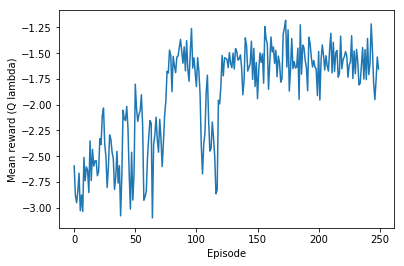

In [157]:
mean_rewards_lbda = [np.mean(rewards_lbda[e]) for e in rewards_lbda]
plt.plot(mean_rewards_lbda)
plt.xlabel("Episode")
plt.ylabel("Mean reward (Q lambda)")
plt.show()

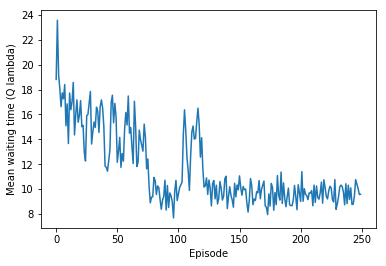

In [158]:
mean_waiting_time_lbda = [np.mean(waiting_times_lbda[e]) for e in waiting_times_lbda]
plt.plot(mean_waiting_time_lbda)
plt.xlabel("Episode")
plt.ylabel("Mean waiting time (Q lambda)")
plt.show()

In [159]:
median_waiting_time_lbda = [np.median(waiting_times_lbda[e]) for e in waiting_times_lbda]

#### Quick comparison between the two algorithms

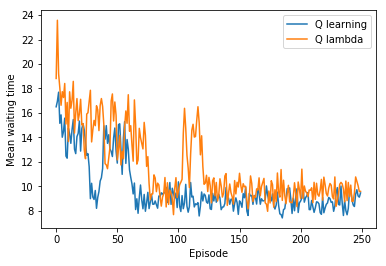

In [160]:
plt.plot(mean_waiting_time, label="Q learning")
plt.plot(mean_waiting_time_lbda, label="Q lambda")
plt.xlabel("Episode")
plt.ylabel("Mean waiting time")
plt.legend()
plt.show()

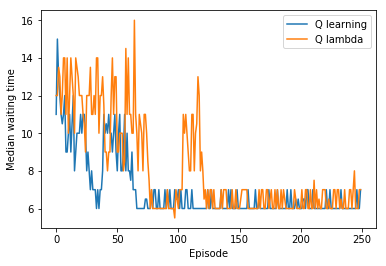

In [161]:
plt.plot(median_waiting_time, label="Q learning")
plt.plot(median_waiting_time_lbda, label="Q lambda")
plt.xlabel("Episode")
plt.ylabel("Median waiting time")
plt.legend()
plt.show()

Both method are very close, although we observe some differences, it is important to take into account the stochastic nature of the environment (and of the epsilon greedy procedure).


Both methods yield an average waiting time close to 8 unit of time. Given the fact that the algorithm are still exploring even after several episodes, we plotted the median value which is less sensible to potential outliers caused by exploration. This yields 

#### Naive method benchmark

A very naive way to control the elevator would be to make follow a repeating cycle going from the ground floor to the top floor and going back down, picking up passenger on the path. We do that below to get an approximation of what would the waiting be if the elevator follows this strategy.

In [170]:
next_move = [1,1,1,1,-1,-1,-1,-1] * 100 #this sequence represents the cycle
rewards_naive = {}
waiting_times_naive = {}
for ep in range(200):
    ev = ELEVATOR()
    rewards_naive[ep] = []
    for t in next_move:
        ev.generate_calls()
        ev.move(t)
        rewards_naive[ep].append(-ev.occupancy - sum(ev.calls.values()))
    waiting_times_naive[ep] = ev.waiting_times

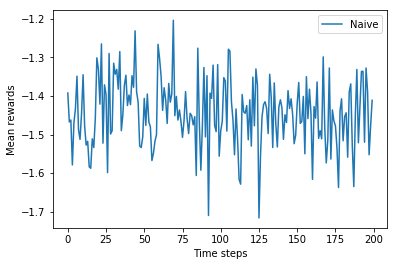

In [173]:
plt.plot([np.mean(rewards_naive[e]) for e in rewards_naive], label="Naive")
plt.xlabel("Time steps")
plt.ylabel("Mean rewards")
plt.legend()
plt.show()

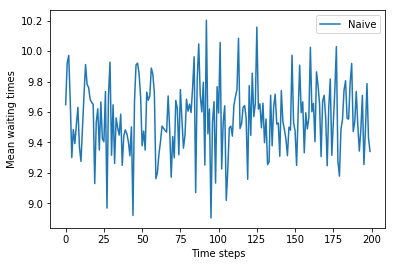

In [172]:
plt.plot([np.mean(waiting_times_naive[e]) for e in waiting_times_naive], label="Naive")
plt.xlabel("Time steps")
plt.ylabel("Mean waiting times")
plt.legend()
plt.show()

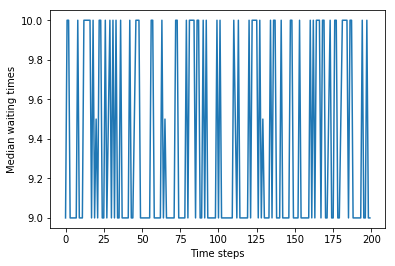

In [175]:
plt.plot([np.median(waiting_times_naive[e]) for e in waiting_times_naive], label="Naive")
plt.xlabel("Time steps")
plt.ylabel("Median waiting times")
plt.show()

We see that this simple heuristic performs rather well but our Q learning model does better, the median waiting time being around 6 while here it is 9.5. However, the heuristic is certainly highly dependant on the call probability distribution but gives a good benchmark in the context of a simple modelisation of the elevator as it is the case here. We think the gap would be larger with a higher height of the building.

Furthermore, by visually analyzing the naive approach and the qlearning one, we see that for example, if the elevator finds itself on the 2 floor with 2 passengers and a call is made on floor 3. The methods obtained with Q learning will go up to pick the new passenger while this naive heuristic will go up only if it was on its way up. These kind of scenario can happen a lot and the q learning approach will do a better job in such situations. 

# Conclusion

We have implemented a simple environment to model an Elevator and Q learning algorithms to find a good policy, following the model defined in "Reinforcement Learning for Elevator Control" (Yuan 2008).
We found rather satisfying results although the performance is not very far from a naive approach. Further work could consist in relaxing some of the assumption that were made in order to make the model more realistic and try other approaches to solve the problem.
Indeed, if we go towards a more realistic setting, the Q learning algorithm won't be possible simply because we could not store all the state action values, because of a space too big. One might want to turn towards Deep Q learning for example. 